In [37]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # model will be trained on GPU 1
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

In [38]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [39]:
train_data = extract_data('data/train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('data/t10k-images-idx3-ubyte.gz', 10000)

In [40]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [41]:
train_labels = extract_labels('data/train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('data/t10k-labels-idx1-ubyte.gz',10000)

In [42]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [43]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

Text(0.5, 1.0, '(Label: D)')

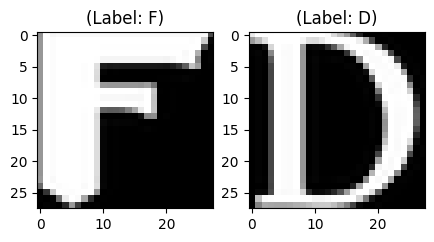

In [44]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

***Data Preprocessing***

In [45]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [46]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [47]:
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [50]:
# Normalization
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [51]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [52]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)

***Convolutional Autoencoder***

In [53]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = 28, 28

In [55]:
input_img = Input(shape = (x, y, inChannel))

In [57]:
def autoencoder(input_img):
    #encoder
    # input = 28x28x1 (widthxheightxthin)
    # conv-1
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1) #14 x 14 x 32
    # conv-2
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2) #7 x 7 x 64
    # conv-3
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    
    #decoder
    # conv-4
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    # conv-5
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [58]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

2023-12-08 19:43:46.152189: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-08 19:43:46.152228: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: kazi
2023-12-08 19:43:46.152233: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: kazi
2023-12-08 19:43:46.152363: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.86.10
2023-12-08 19:43:46.152383: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.86.10
2023-12-08 19:43:46.152387: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.86.10


In [59]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856 

***Train the model***

In [60]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/50
375/375 [==============================] - 61s 161ms/step - loss: 0.0449 - val_loss: 0.0188
Epoch 2/50
375/375 [==============================] - 60s 160ms/step - loss: 0.0157 - val_loss: 0.0131
Epoch 3/50
375/375 [==============================] - 60s 161ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 4/50
375/375 [==============================] - 60s 160ms/step - loss: 0.0093 - val_loss: 0.0083
Epoch 5/50
375/375 [==============================] - 60s 160ms/step - loss: 0.0081 - val_loss: 0.0074
Epoch 6/50
375/375 [==============================] - 60s 161ms/step - loss: 0.0073 - val_loss: 0.0067
Epoch 7/50
375/375 [==============================] - 60s 160ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 8/50
375/375 [==============================] - 60s 160ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 9/50
375/375 [==============================] - 60s 161ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 10/50
375/375 [==============================] - 60s 160ms/step - l

**Training vs Validation Loss Plot**

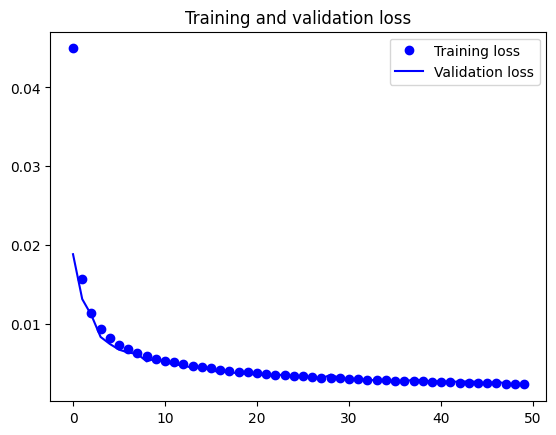

In [61]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [62]:
pred = autoencoder.predict(test_data)

313/313 [==============================] - 2s 7ms/step


In [63]:
pred.shape

(10000, 28, 28, 1)

Test Images


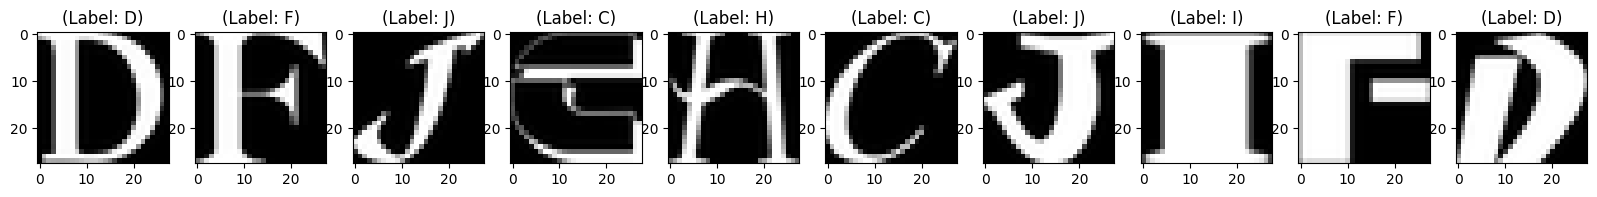

Reconstruction of Test Images


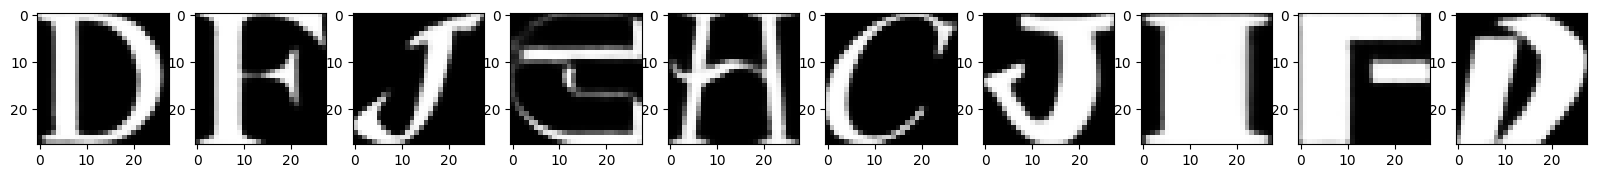

In [64]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

***Denoising Autoencoder***

In [65]:
noise_factor = 0.5
x_train_noisy = train_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_X.shape)
x_valid_noisy = valid_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_X.shape)
x_test_noisy = test_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

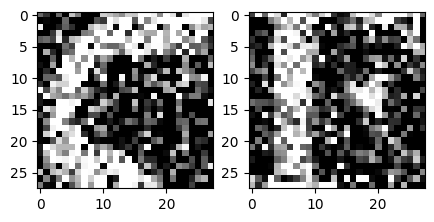

In [66]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(x_train_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(x_test_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

In [67]:
batch_size = 128
epochs = 20
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [68]:
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

In [69]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [70]:
autoencoder_train = autoencoder.fit(x_train_noisy, train_X, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid_noisy, valid_X))

Epoch 1/20
375/375 [==============================] - 61s 162ms/step - loss: 0.0614 - val_loss: 0.0387
Epoch 2/20
375/375 [==============================] - 58s 155ms/step - loss: 0.0297 - val_loss: 0.0279
Epoch 3/20
375/375 [==============================] - 59s 157ms/step - loss: 0.0251 - val_loss: 0.0231
Epoch 4/20
375/375 [==============================] - 64s 170ms/step - loss: 0.0229 - val_loss: 0.0211
Epoch 5/20
375/375 [==============================] - 61s 162ms/step - loss: 0.0216 - val_loss: 0.0202
Epoch 6/20
375/375 [==============================] - 63s 167ms/step - loss: 0.0207 - val_loss: 0.0197
Epoch 7/20
375/375 [==============================] - 62s 165ms/step - loss: 0.0200 - val_loss: 0.0192
Epoch 8/20
375/375 [==============================] - 61s 163ms/step - loss: 0.0194 - val_loss: 0.0190
Epoch 9/20
375/375 [==============================] - 63s 169ms/step - loss: 0.0190 - val_loss: 0.0188
Epoch 10/20
375/375 [==============================] - 68s 181ms/step - l

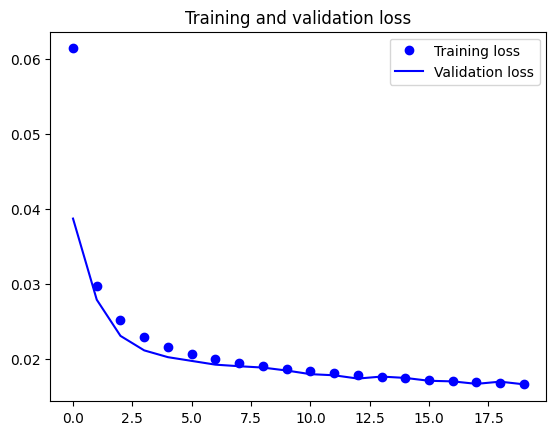

In [71]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Test Images


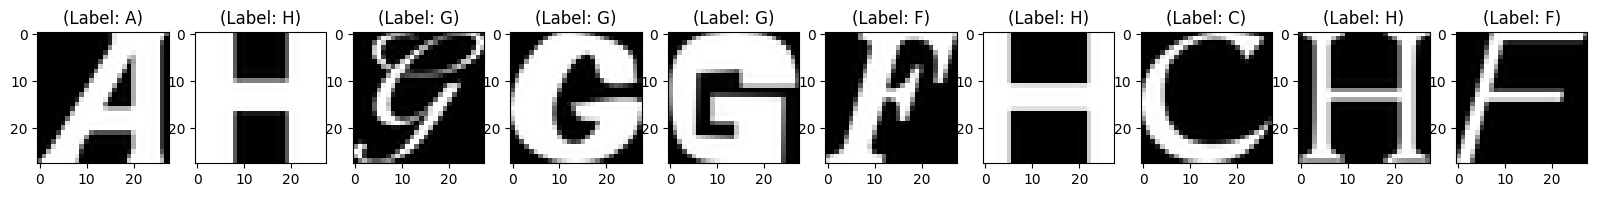

Test Images with Noise


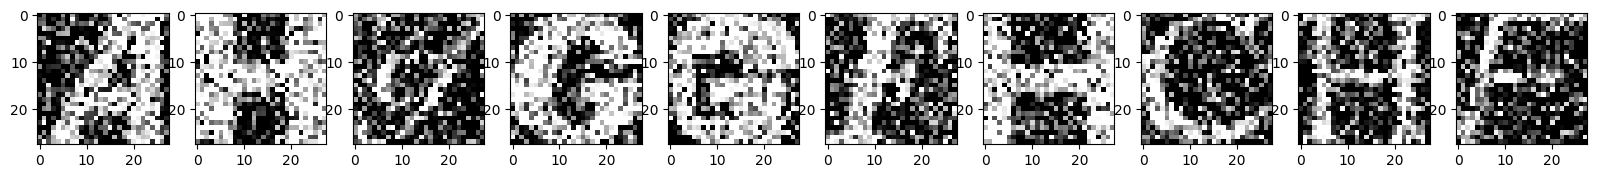

Reconstruction of Noisy Test Images


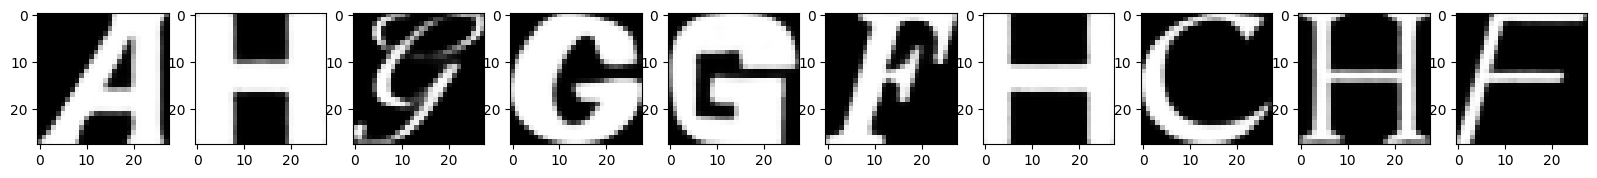

In [72]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()